# EE4305 CIFAR-10 Image Classification Project -- Jeffrey Leong, A0192710L

# Brief Overview


This ipynb notebook only provides a reference to my code for showing proof of work conducted for the EE4305 project. Therefore, this notebook will be minimally descriptive as the report should be referenced as needed.

All results are from training on 3-class unless otherwise explicitly stated. To run, only the 10 class or 3 class dataset should be loaded; the models will infer the number of the classes loaded when compiled. 

# Setup

## Import

In [0]:
import time

import matplotlib.pyplot as plt
import numpy as np
from keras.optimizers import SGD, Adagrad, Adadelta, Adam,Nadam, Adamax, RMSprop


from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.constraints import maxnorm
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint


from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization


from keras.utils import np_utils
from keras import backend as K

from keras.datasets import cifar10

import sys
import os


Using TensorFlow backend.


## Tensorflow and GPU runtime

In [0]:
import tensorflow as tf

# check GPU type and ram memory
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# check if GPU runtime is setup for Colab
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


# check ram memory
# !cat /proc/meminfo

Found GPU at: /device:GPU:0


## Data

### Load 10 set

In [0]:
# download data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()  

# More Preprocessing/initialization
nb_epoch = 100
batch_size = 128
nb_classes = 10 # SET NUM of CLASSES

# flatten done using keras instead
# X_train = X_train.reshape(len(X_train), 32 * 32 * 3)
# X_test = X_test.reshape(len(X_test), 32 * 32 * 3)

X_train = x_train.astype('float32')
X_test = x_test.astype('float32')
X_train /= 255.0 # normalize 8-bit pixels
X_test /= 255.0

# convert the labels in the dataset into categorical matrix structure from 1-dim numpy array structure
# one hot encode
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

170500096/170498071 [==============================] - 44s 0us/step


### Load 3 class subset

In [0]:
# download data
(x_train, y_train), (x_test, y_test) = cifar10.load_data() 

# Reduce sizes of classes to 1 = car, 2 = birds 3 = cat (arbitrarially chosen)
class_set_train = (y_train == 1) | (y_train == 2) | (y_train == 3)
class_set_test = (y_test == 1) | (y_test == 2) | (y_test == 3)

X_train = np.compress(np.ravel(class_set_train), x_train, axis=0)
y_train = np.compress(np.ravel(class_set_train), y_train, axis=0) - 1 # minus 1 so first class is now 0!!!
X_test = np.compress(np.ravel(class_set_test), x_test, axis=0)
y_test = np.compress(np.ravel(class_set_test), y_test, axis=0) - 1


#---------------------------------------------------------
# Reduce number of examples for above subset
# setred = 1650 #reduction in set size so we have 10,050
# classes = set([1 -1, 2 -1, 3 -1])  # reduced classes set from above
# cnt = [0,0,0]
# i = 0
# mask = np.ones(len(X_train), dtype=bool)

# while (cnt[0] < setred or cnt[1] < setred or cnt[2] < setred):
#   y = y_train[i,0]
#   if (y in classes and cnt[y] < setred):
#     cnt[y]+=1
#     mask[i] = False
# #     X_train = np.delete(X_train, i, axis=0)
# #     y_train = np.delete(y_train, i, axis=0)
    
#   if (i == X_train.shape[0]):
#     print('failed to reduce ')
#     print(str(cnt))
#     break
#   i+=1

# X_train = X_train[mask]
# y_train = y_train[mask]
# print('new size: ' + str(X_train.shape[0]))
#---------------------------------------------------------

# More Preprocessing/initialization
nb_epoch = 100
batch_size = 128
nb_classes = 3 # SET NUM of CLASSES

# flatten done using keras instead
# X_train = X_train.reshape(len(X_train), 32 * 32 * 3)
# X_test = X_test.reshape(len(X_test), 32 * 32 * 3)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0 # normalize 8-bit pixels
X_test /= 255.0

# convert the labels in the dataset into categorical matrix structure from 1-dim numpy array structure
# one hot encode
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

## Utility Functions

In [0]:
# mounting drive
from google.colab import drive
drive.mount('/gdrive')

# check mounted by listing
# !ls 
# sys.path.insert(0, '/gdrive/My Drive/Misc Projects/ML_proj/NNproj_cifar10') # create a new folder
os.chdir("/gdrive/My Drive/Misc Projects/ML_proj/NNproj_cifar10") # change dir to new folder

def savemodel(model, mod_name):
  model.save(mod_name + '.hf')
  model.save_weights(mod_name + '_weights.hdf')
  
# def savemodel(model, mod_name, filepath):
#   model.load_weights(filepath)
# #   model_copy.save(model_name + '.hf')
#   model.save_weights(mod_name + '_weights.hdf5')
  
def loadmodel(mod, mod_name, weightspath):
#   trained_filepath = 'trained_simmod.hdf'
  model = mod()
  return model.load_weights(weightspath)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
def plot_model_history(model_history, name = 'model', plotacc = True, plotloss = True):
    if plotacc and plotloss:
      fig, axs = plt.subplots(1,2,figsize=(15,5))
      # summarize history for accuracy
      axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
      axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
      axs[0].set_title(name + ' Accuracy')
      axs[0].set_ylabel('Accuracy')
      axs[0].set_xlabel('Epoch')
      axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
      axs[0].legend(['train', 'val'], loc='best')
      # summarize history for loss
      axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
      axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
      axs[1].set_title(name + ' Loss')
      axs[1].set_ylabel('Loss')
      axs[1].set_xlabel('Epoch')
      axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
      axs[1].legend(['train', 'val'], loc='best')
      plt.show()
    elif plotloss and not plotacc:
      plt.plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
      plt.plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
      plt.title(name + ' Loss')
      plt.ylabel('Loss')
      plt.xlabel('Epoch')
#       xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
      plt.legend(['train', 'val'], loc='best')
      plt.show()
    elif plotacc and not plotloss:
      plt.plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
      plt.plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
      plt.title(name + ' Acc')
      plt.ylabel('Acc')
      plt.xlabel('Epoch')
#       xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
      plt.legend(['train', 'val'], loc='best')
      plt.show()
      

In [0]:
# a basic model trainer generation function for mass testing

def model_trainer(mod, name, epochs = 10, opt = Adam(), lossfun = 'categorical_crossentropy', batch_size=128,  save = False):
  print('Training model: ' + name)
  
  # save best weights over all epochs
  filepath="/tmp/"+ name + "bestweights.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  callbacks_list = [checkpoint]
  
    
  mod.compile(loss = lossfun, optimizer = opt, metrics=['accuracy'])
#   mod.summary()
  start_time = time.time()
  hist = mod.fit(X_train, Y_train, batch_size=128, epochs=epochs, validation_data=(X_test,Y_test), callbacks = callbacks_list)
  elapsed_time = time.time() - start_time
  
  if save == True:
    savemodel(mod, name)
  
  return (hist, elapsed_time)

# Part 1: MLP Architecture for Classification

## Model 1: Basic MLP

In [0]:
# MLP
model = Sequential()
model.add(Flatten(input_shape=X_train.shape[1:]))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
opt = SGD(lr=0.01, momentum=0.9, decay=0, nesterov=False)
model.compile(loss='categorical_crossentropy',
              optimizer= opt,
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_24 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_68 (Dense)             (None, 512)               1573376   
_________________________________________________________________
activation_75 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_76 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 256)               0         
__________

In [0]:
# training
start_time = time.time()
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    nb_epoch=nb_epoch,
                    verbose=1,
                    validation_data=(X_test, Y_test))
elapsed_time = time.time() - start_time
model.save('/tmp/cifar10.h5', overwrite=True)


/usr/local/lib/python3.6/dist-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 15000 samples, validate on 3000 samples
Epoch 1/100
15000/15000 [==============================] - 2s 139us/step - loss: 9.7145 - acc: 0.4761 - val_loss: 9.5151 - val_acc: 0.6083
Epoch 2/100
15000/15000 [==============================] - 1s 66us/step - loss: 9.4422 - acc: 0.5775 - val_loss: 9.3002 - val_acc: 0.6280
Epoch 3/100
15000/15000 [==============================] - 1s 67us/step - loss: 9.2374 - acc: 0.6149 - val_loss: 9.1145 - val_acc: 0.6367
Epoch 4/100
15000/15000 [==============================] - 1s 67us/step - loss: 9.0472 - acc: 0.6330 - val_loss: 8.9440 - val_acc: 0.6430
Epoch 5/100
15000/15000 [==============================] - 1s 66us/step - loss: 8.8736 - acc: 0.6437 - val_loss: 8.7682 - val_acc: 0.6573
Epoch 6/100
15000/15000 [==============================] - 1s 67us/step - loss: 8.7038 - acc: 0.6618 - val_loss: 8.6117 - val_acc: 0.6573
Epoch 7/100
15000/15000 [==============================] - 1s 67us/step - loss: 8.5424 - acc: 0.6698 - val_loss: 8.4439 - 

In [0]:
scores = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Total training time:', elapsed_time)

3000/3000 [==============================] - 0s 95us/step
Test loss: 1.9136685228347778
Test accuracy: 0.783
Total training time: 101.76765131950378


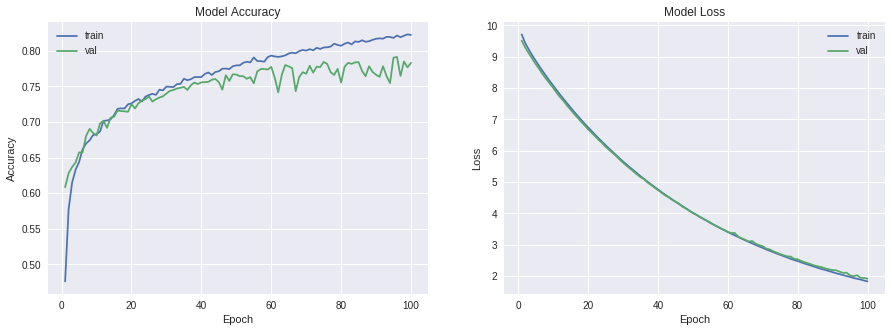

In [0]:
plot_model_history(history)

## Model 2 : Experimenting with regularization

In [0]:
# MLP
model = Sequential()
model.add(Flatten(input_shape=X_train.shape[1:]))
model.add(Dense(512, kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.2))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

opt = SGD(lr=0.002, momentum=0.4, decay=0, nesterov=True)
# opt = Adam()
model.compile(loss='categorical_crossentropy',
              optimizer= opt,
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_34 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_98 (Dense)             (None, 512)               1573376   
_________________________________________________________________
activation_105 (Activation)  (None, 512)               0         
_________________________________________________________________
dropout_70 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_99 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_106 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 256)               0         
__________

In [0]:
# training
start_time = time.time()
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    nb_epoch=nb_epoch,
                    verbose=1,
                    validation_data=(X_test, Y_test))
elapsed_time = time.time() - start_time
model.save('/tmp/cifar10_MLP2.h5', overwrite=True)


/usr/local/lib/python3.6/dist-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 15000 samples, validate on 3000 samples
Epoch 1/100
15000/15000 [==============================] - 2s 157us/step - loss: 9.7240 - acc: 0.4750 - val_loss: 9.5347 - val_acc: 0.6103
Epoch 2/100
15000/15000 [==============================] - 1s 69us/step - loss: 9.4789 - acc: 0.5829 - val_loss: 9.3436 - val_acc: 0.6417
Epoch 3/100
15000/15000 [==============================] - 1s 69us/step - loss: 9.2970 - acc: 0.6163 - val_loss: 9.1877 - val_acc: 0.6450
Epoch 4/100
15000/15000 [==============================] - 1s 69us/step - loss: 9.1393 - acc: 0.6295 - val_loss: 9.0351 - val_acc: 0.6643
Epoch 5/100
15000/15000 [==============================] - 1s 69us/step - loss: 8.9860 - acc: 0.6496 - val_loss: 8.8870 - val_acc: 0.6730
Epoch 6/100
15000/15000 [==============================] - 1s 69us/step - loss: 8.8434 - acc: 0.6567 - val_loss: 8.7512 - val_acc: 0.6777
Epoch 7/100
15000/15000 [==============================] - 1s 69us/step - loss: 8.7056 - acc: 0.6617 - val_loss: 8.6304 - 

In [0]:
scores = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Total training time:', elapsed_time)
plot_model_history(history)

3000/3000 [==============================] - 0s 88us/step
Test loss: 2.388353993097941
Test accuracy: 0.7803333331743876
Total training time: 106.10450482368469


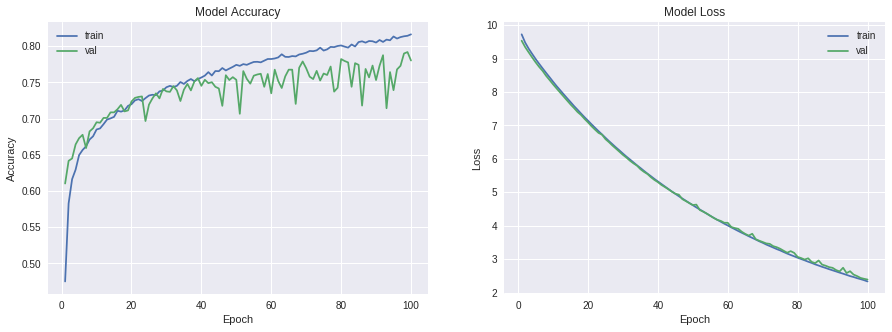

In [0]:
# plot_model_history(history)

## More Epochs & w/ LR Schedule

In [0]:
def lr_schedule(epoch):
    lrate = 0.002
    if epoch > 50:
        lrate = 0.001
    elif epoch > 100:
        lrate = 0.0005  
    elif epoch > 200:
        lrate = 0.00025    
    elif epoch > 250:
        lrate = 0.000125   
    return lrate

In [0]:
# MLP
model = Sequential()
model.add(Flatten(input_shape=X_train.shape[1:]))
model.add(Dense(512, kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
opt = SGD(lr=0.00, momentum=0.4, decay=0, nesterov=True)
# opt = Adam()
model.compile(loss='categorical_crossentropy',
              optimizer= opt,
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_14 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 512)               1573376   
_________________________________________________________________
activation_62 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_63 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 256)               0         
__________

In [0]:
# training
epoch = 150
start_time = time.time()
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    nb_epoch=epoch,
                    verbose=1,
                    validation_data=(X_test, Y_test),
                    callbacks=[LearningRateScheduler(lr_schedule)])
elapsed_time = time.time() - start_time
model.save('/tmp/cifar10_MLP_long.h5', overwrite=True)

/usr/local/lib/python3.6/dist-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 15000 samples, validate on 3000 samples
Epoch 1/300
15000/15000 [==============================] - 3s 209us/step - loss: 9.7750 - acc: 0.4432 - val_loss: 9.5926 - val_acc: 0.5857
Epoch 2/300
15000/15000 [==============================] - 1s 85us/step - loss: 9.5340 - acc: 0.5483 - val_loss: 9.4015 - val_acc: 0.6083
Epoch 3/300
15000/15000 [==============================] - 1s 87us/step - loss: 9.3547 - acc: 0.5862 - val_loss: 9.2322 - val_acc: 0.6317
Epoch 4/300
15000/15000 [==============================] - 1s 84us/step - loss: 9.1906 - acc: 0.6069 - val_loss: 9.0778 - val_acc: 0.6423
Epoch 5/300
15000/15000 [==============================] - 1s 84us/step - loss: 9.0340 - acc: 0.6280 - val_loss: 8.9428 - val_acc: 0.6430
Epoch 6/300
15000/15000 [==============================] - 1s 83us/step - loss: 8.8892 - acc: 0.6381 - val_loss: 8.7906 - val_acc: 0.6547
Epoch 7/300
15000/15000 [==============================] - 1s 88us/step - loss: 8.7472 - acc: 0.6415 - val_loss: 8.6607 - 

3000/3000 [==============================] - 0s 109us/step
Test loss: 1.1059693667093913
Test accuracy: 0.7949999998410543
Total training time: 365.4681990146637


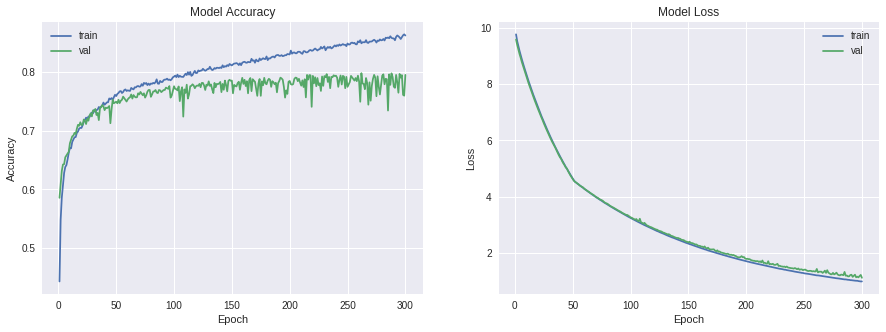

In [0]:
scores = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Total training time:', elapsed_time)
plot_model_history(history)

## More Layers

In [0]:
def lr_schedule(epoch):
    lrate = 0.002
    if epoch > 70:
        lrate = 0.001
    elif epoch > 100:
        lrate = 0.0005  
    elif epoch > 125:
        lrate = 0.0001    
    return lrate
  
# MLP
model = Sequential()
model.add(Flatten(input_shape=X_train.shape[1:]))
model.add(Dense(512, kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))


model.add(Dense(256))
model.add(Activation('relu'))


model.add(Dense(128))
model.add(Activation('relu'))


model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
opt = SGD(lr=0.0, momentum=0.4, decay=0, nesterov=True)
# opt = Adam()
model.compile(loss='categorical_crossentropy',
              optimizer= opt,
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_90 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_102 (Dense)            (None, 512)               1573376   
_________________________________________________________________
activation_618 (Activation)  (None, 512)               0         
_________________________________________________________________
dense_103 (Dense)            (None, 256)               131328    
_________________________________________________________________
activation_619 (Activation)  (None, 256)               0         
_________________________________________________________________
dense_104 (Dense)            (None, 128)               32896     
_________________________________________________________________
activation_620 (Activation)  (None, 128)               0         
__________

In [0]:
# training
epoch = 150
start_time = time.time()
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    nb_epoch=epoch,
                    verbose=1,
                    validation_data=(X_test, Y_test),
                    callbacks=[LearningRateScheduler(lr_schedule)])
elapsed_time = time.time() - start_time

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 15000 samples, validate on 3000 samples
Epoch 1/150
15000/15000 [==============================] - 20s 1ms/step - loss: 9.7605 - acc: 0.4866 - val_loss: 9.6431 - val_acc: 0.5690
Epoch 2/150
15000/15000 [==============================] - 2s 101us/step - loss: 9.5331 - acc: 0.6040 - val_loss: 9.4267 - val_acc: 0.6173
Epoch 3/150
15000/15000 [==============================] - 2s 101us/step - loss: 9.3302 - acc: 0.6259 - val_loss: 9.2390 - val_acc: 0.6300
Epoch 4/150
15000/15000 [==============================] - 2s 102us/step - loss: 9.1515 - acc: 0.6444 - val_loss: 9.0751 - val_acc: 0.6327
Epoch 5/150
15000/15000 [==============================] - 2s 101us/step - loss: 8.9870 - acc: 0.6564 - val_loss: 8.9501 - val_acc: 0.6137
Epoch 6/150
15000/15000 [==============================] - 2s 102us/step - loss: 8.8346 - acc: 0.6685 - val_loss: 8.7791 - val_acc: 0.6530
Epoch 7/150
15000/15000 [==============================] - 1s 100us/step - loss: 8.6914 - acc: 0.6769 - val_loss: 8.63

3000/3000 [==============================] - 1s 205us/step
Test loss: 2.399828177134196
Test accuracy: 0.7903333334922791
Total training time: 264.01273798942566


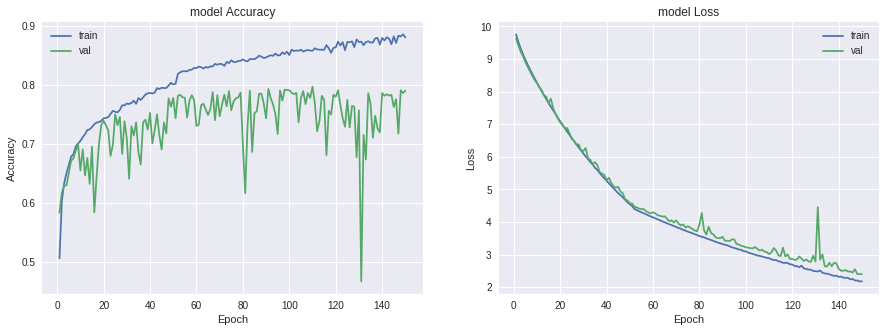

In [0]:
scores = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Total training time:', elapsed_time)
plot_model_history(history)

# CNN Architecture

In [0]:
def base_model():

    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32,(3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(32,(3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())    
#     model.add(Dense(512))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes)) 
    model.add(Activation('softmax'))

#     opt = SGD(lr=0.01, momentum=0.9, decay=0, nesterov=True)
    opt = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

cnn_n = base_model()
cnn_n.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_16 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_17 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 13, 13, 32)        9248      
__________

## Train

In [0]:
# Fit model
start_time = time.time()
cnn = cnn_n.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, validation_data=(X_test,Y_test))
elapsed_time = time.time() - start_time
model.save('/tmp/cifar10_CNN.h5', overwrite=True)

loss, acc = cnn_n.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test acc:', acc)
print('Total training time:', elapsed_time)

Train on 15000 samples, validate on 3000 samples
Epoch 1/100
15000/15000 [==============================] - 3s 203us/step - loss: 0.7580 - acc: 0.6455 - val_loss: 0.5421 - val_acc: 0.7767
Epoch 2/100
15000/15000 [==============================] - 2s 163us/step - loss: 0.5201 - acc: 0.7755 - val_loss: 0.4834 - val_acc: 0.8030
Epoch 3/100
15000/15000 [==============================] - 2s 160us/step - loss: 0.4759 - acc: 0.7965 - val_loss: 0.4517 - val_acc: 0.8023
Epoch 4/100
15000/15000 [==============================] - 2s 163us/step - loss: 0.4472 - acc: 0.8105 - val_loss: 0.4217 - val_acc: 0.8183
Epoch 5/100
15000/15000 [==============================] - 2s 164us/step - loss: 0.4314 - acc: 0.8194 - val_loss: 0.4235 - val_acc: 0.8150
Epoch 6/100
15000/15000 [==============================] - 2s 162us/step - loss: 0.4089 - acc: 0.8298 - val_loss: 0.4041 - val_acc: 0.8283
Epoch 7/100
15000/15000 [==============================] - 2s 162us/step - loss: 0.3983 - acc: 0.8317 - val_loss: 0.3

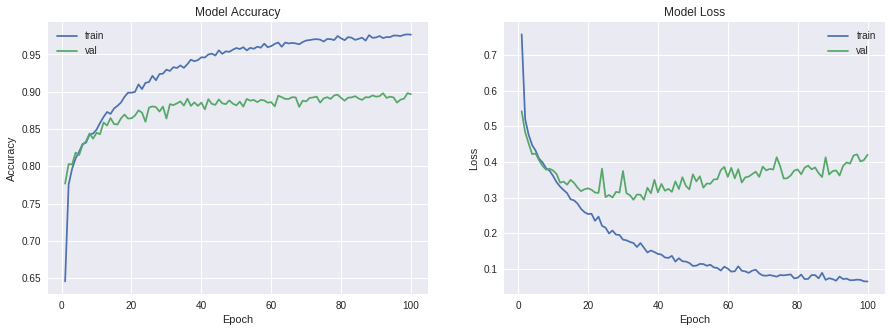

In [0]:
plot_model_history(cnn)

## Train with Batch Normalization and more dropout
(and more conv filters)

In [0]:

def base_model(opt = Adam()):

    model = Sequential()
    model.add(Conv2D(32,(3, 3), padding='same', input_shape=X_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(64,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(128,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.6))
    
    model.add(Flatten())  
    model.add(Dense(nb_classes)) 
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
  
cnn_bn = base_model()
cnn_bn.summary()

filepath="/tmp/CNN_batchn_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_55 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_56 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_57 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 32, 32, 32)        128       
__________

In [0]:
# Fit model
start_time = time.time()
cnn_bn_hist = cnn_bn.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, validation_data=(X_test,Y_test), callbacks=callbacks_list)
elapsed_time = time.time() - start_time
cnn_bn.save('/tmp/cifar10_CNN_bn.h5', overwrite=True)

Train on 15000 samples, validate on 3000 samples
Epoch 1/100
15000/15000 [==============================] - 7s 497us/step - loss: 1.2217 - acc: 0.6382 - val_loss: 0.7709 - val_acc: 0.6877

Epoch 00001: val_acc improved from -inf to 0.68767, saving model to /tmp/CNN_batchn_weights.best.hdf5
Epoch 2/100
15000/15000 [==============================] - 6s 385us/step - loss: 0.6775 - acc: 0.7345 - val_loss: 0.6233 - val_acc: 0.7167

Epoch 00002: val_acc improved from 0.68767 to 0.71667, saving model to /tmp/CNN_batchn_weights.best.hdf5
Epoch 3/100
15000/15000 [==============================] - 6s 385us/step - loss: 0.5686 - acc: 0.7699 - val_loss: 0.7793 - val_acc: 0.6783

Epoch 00003: val_acc did not improve from 0.71667
Epoch 4/100
15000/15000 [==============================] - 6s 383us/step - loss: 0.5230 - acc: 0.7923 - val_loss: 0.5231 - val_acc: 0.7923

Epoch 00004: val_acc improved from 0.71667 to 0.79233, saving model to /tmp/CNN_batchn_weights.best.hdf5
Epoch 5/100
15000/15000 [====

Test loss: 0.24065717867016792
Test acc: 0.9213333331743876
Total training time: 579.1046419143677
Test loss: 0.20708736022313437
Test acc: 0.9293333333333333


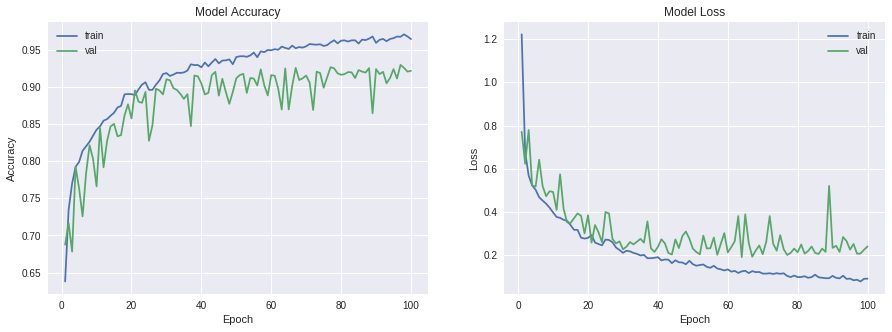

In [0]:
loss, acc = cnn_bn.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test acc:', acc)
print('Total training time:', elapsed_time)

best_model = base_model()
best_model.load_weights(filepath)
loss, acc = best_model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test acc:', acc)

plot_model_history(cnn_bn_hist)

## General CNN for Baseline Testing (simplenet)

In [0]:
def Simmodel():

    model = Sequential()
    model.add(Conv2D(32,(3, 3), padding='same', input_shape=X_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
#     model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(64,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64,(3, 3), padding='same'))
    model.add(Activation('relu'))
#     model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(128,(3, 3), padding='same'))
    model.add(Activation('relu'))
#     model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.6))
    
    model.add(Flatten())  
    model.add(Dense(nb_classes)) 
    model.add(Activation('softmax'))
    

    return model

In [0]:
Simmodel().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_3 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
__________

### Baseline model (baseline_simmodel)

In [0]:
simmodel = Simmodel()
[hist,s] = model_trainer(simmodel, 'baseline_simmodel', 100, Adam(), 'categorical_crossentropy', batch_size=128,  save = True)

Training model: baseline_simmodel
Train on 10050 samples, validate on 3000 samples
Epoch 1/100
10050/10050 [==============================] - 5s 524us/step - loss: 0.8631 - acc: 0.5565 - val_loss: 0.6252 - val_acc: 0.7387

Epoch 00001: val_acc improved from -inf to 0.73867, saving model to /tmp/baseline_simmodelbestweights.hdf5
Epoch 2/100
10050/10050 [==============================] - 3s 328us/step - loss: 0.5673 - acc: 0.7444 - val_loss: 0.5051 - val_acc: 0.7737

Epoch 00002: val_acc improved from 0.73867 to 0.77367, saving model to /tmp/baseline_simmodelbestweights.hdf5
Epoch 3/100
10050/10050 [==============================] - 3s 328us/step - loss: 0.5264 - acc: 0.7649 - val_loss: 0.5160 - val_acc: 0.7627

Epoch 00003: val_acc did not improve from 0.77367
Epoch 4/100
10050/10050 [==============================] - 3s 327us/step - loss: 0.4986 - acc: 0.7843 - val_loss: 0.4653 - val_acc: 0.7977

Epoch 00004: val_acc improved from 0.77367 to 0.79767, saving model to /tmp/baseline_simmo

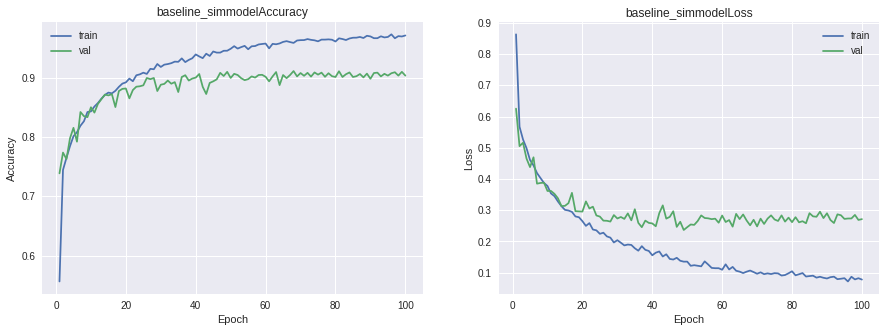

In [0]:
plot_model_history(hist, 'baseline_simmodel')

### Activation Function

#### ELU

In [0]:
def elu_model():

    model = Sequential()
    model.add(Conv2D(32,(3, 3), padding='same', input_shape=X_train.shape[1:]))
    model.add(Activation('elu'))
    model.add(Conv2D(32,(3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(Conv2D(32,(3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(64,(3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(Conv2D(64,(3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(128,(3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.65))
    
    model.add(Flatten())  
    model.add(Dense(nb_classes)) 
    model.add(Activation('softmax'))
    
    opt = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
  
cnn_elu = elu_model()
cnn_elu.summary()

filepath="/tmp/CNN_elu_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_10 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 32)        128       
__________

In [0]:
# Fit model
nb_epoch = 100
start_time = time.time()
cnn_elu_hist = cnn_elu.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, validation_data=(X_test,Y_test), callbacks=callbacks_list)
elapsed_time = time.time() - start_time
cnn_elu.save('/tmp/cifar10_CNN_elu.h5', overwrite=True)

Train on 15000 samples, validate on 3000 samples
Epoch 1/100
15000/15000 [==============================] - 20s 1ms/step - loss: 1.2825 - acc: 0.6272 - val_loss: 1.2968 - val_acc: 0.5943

Epoch 00001: val_acc improved from -inf to 0.59433, saving model to /tmp/CNN_elu_weights.best.hdf5
Epoch 2/100
15000/15000 [==============================] - 13s 883us/step - loss: 0.7698 - acc: 0.7128 - val_loss: 2.6796 - val_acc: 0.4100

Epoch 00002: val_acc did not improve from 0.59433
Epoch 3/100
15000/15000 [==============================] - 14s 901us/step - loss: 0.6418 - acc: 0.7468 - val_loss: 1.1517 - val_acc: 0.5613

Epoch 00003: val_acc did not improve from 0.59433
Epoch 4/100
15000/15000 [==============================] - 13s 896us/step - loss: 0.5833 - acc: 0.7667 - val_loss: 0.5584 - val_acc: 0.7647

Epoch 00004: val_acc improved from 0.59433 to 0.76467, saving model to /tmp/CNN_elu_weights.best.hdf5
Epoch 5/100
15000/15000 [==============================] - 13s 879us/step - loss: 0.5309

Test loss: 0.2043001963297526
Test acc: 0.9343333334922791
Total training time: 1348.0142827033997
Test loss: 0.18825589814782143
Test acc: 0.9383333331743876


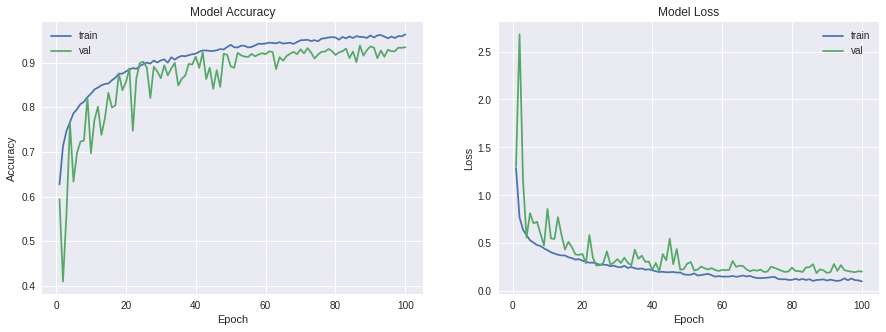

In [0]:
loss, acc = cnn_elu.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test acc:', acc)
print('Total training time:', elapsed_time)

best_model = elu_model()
best_model.load_weights(filepath)
loss, acc = best_model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test acc:', acc)

plot_model_history(cnn_elu_hist)

### Objective Functions Comparison

In [0]:
# ref: model_trainer(Simmodel, 'baseline_simmodel', 100, Adam(), 'categorical_crossentropy', batch_size=128,  save = True)


mod_hist = []
_time = []
epochs = 15
names = ['objfun_crossent', 'objfun_mse', 'objfun_ch', 'objfun_msle', 'objfun_kld', 'objfun_cos_prox']

### comparing training on early stage learning
simmodel = Simmodel()
hist,_t  = model_trainer(simmodel, names[0], epochs, Adam(), 'categorical_crossentropy')
mod_hist.append(hist)

simmodel = Simmodel()
hist,_t  = model_trainer(simmodel, names[1], epochs, Adam(), 'mean_squared_error')
mod_hist.append(hist)

simmodel = Simmodel()
hist,_t = model_trainer(simmodel, names[2], epochs, Adam(), 'categorical_hinge')
mod_hist.append(hist)

simmodel = Simmodel()
hist,_t = model_trainer(simmodel, names[3], epochs, Adam(), 'mean_squared_logarithmic_error')
mod_hist.append(hist)

simmodel = Simmodel()
hist,_t = model_trainer(simmodel, names[4], epochs, Adam(), 'kullback_leibler_divergence')
mod_hist.append(hist)

simmodel = Simmodel()
hist,_t = model_trainer(simmodel, names[5], epochs, Adam(), 'cosine_proximity')
mod_hist.append(hist)


### compare training on saturated model learning
# trained_model = loadmodel(Simmodel,'baseline_simmodel')
trained_model = Simmodel()
trained_model.load_weights('baseline_simmodel' + '_weights.hdf')
hist,_t = model_trainer(trained_model, names[0]+'_sat', epochs, Adam(), 'categorical_crossentropy')
mod_hist.append(hist)

trained_model = Simmodel()
trained_model.load_weights('baseline_simmodel' + '_weights.hdf')
hist,_t = model_trainer(trained_model, names[1]+'_sat', epochs, Adam(), 'mean_squared_error')
mod_hist.append(hist)

trained_model = Simmodel()
trained_model.load_weights('baseline_simmodel' + '_weights.hdf')
hist,_t = model_trainer(trained_model, names[2]+'_sat', epochs, Adam(), 'categorical_hinge')
mod_hist.append(hist)

trained_model = Simmodel()
trained_model.load_weights('baseline_simmodel' + '_weights.hdf')
hist,_t = model_trainer(trained_model, names[3]+'_sat', epochs, Adam(), 'mean_squared_logarithmic_error')
mod_hist.append(hist)

trained_model = Simmodel()
trained_model.load_weights('baseline_simmodel' + '_weights.hdf')
hist,_t = model_trainer(trained_model, names[4]+'_sat', epochs, Adam(), 'kullback_leibler_divergence')
mod_hist.append(hist)

trained_model = Simmodel()
trained_model.load_weights('baseline_simmodel' + '_weights.hdf')
hist,_t = model_trainer(trained_model, names[5]+'_sat', epochs, Adam(), 'cosine_proximity')
mod_hist.append(hist)

Training model: objfun_crossent
Train on 15000 samples, validate on 3000 samples
Epoch 1/15
15000/15000 [==============================] - 6s 429us/step - loss: 0.8408 - acc: 0.5802 - val_loss: 0.6089 - val_acc: 0.7357

Epoch 00001: val_acc improved from -inf to 0.73567, saving model to /tmp/objfun_crossentbestweights.hdf5
Epoch 2/15
15000/15000 [==============================] - 5s 313us/step - loss: 0.5729 - acc: 0.7477 - val_loss: 0.5244 - val_acc: 0.7727

Epoch 00002: val_acc improved from 0.73567 to 0.77267, saving model to /tmp/objfun_crossentbestweights.hdf5
Epoch 3/15
15000/15000 [==============================] - 5s 316us/step - loss: 0.5207 - acc: 0.7738 - val_loss: 0.4822 - val_acc: 0.7963

Epoch 00003: val_acc improved from 0.77267 to 0.79633, saving model to /tmp/objfun_crossentbestweights.hdf5
Epoch 4/15
15000/15000 [==============================] - 5s 311us/step - loss: 0.4790 - acc: 0.7920 - val_loss: 0.4570 - val_acc: 0.8150

Epoch 00004: val_acc improved from 0.79633

#### Acc comparison

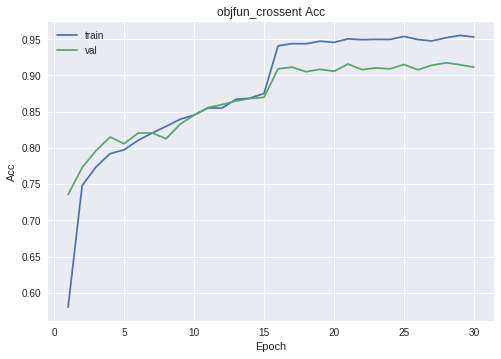

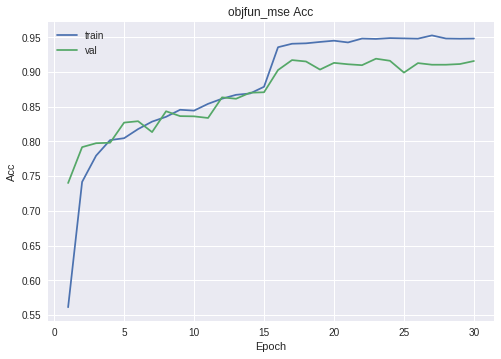

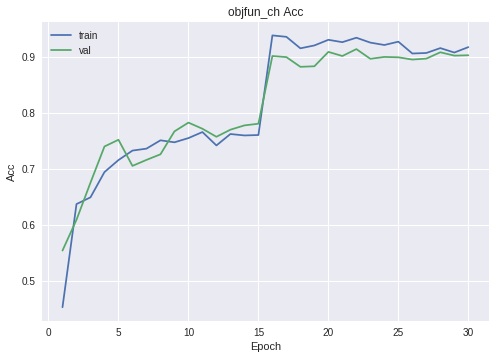

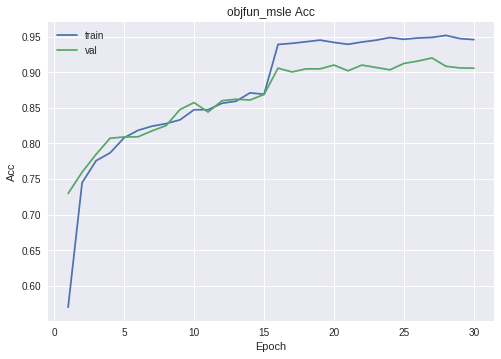

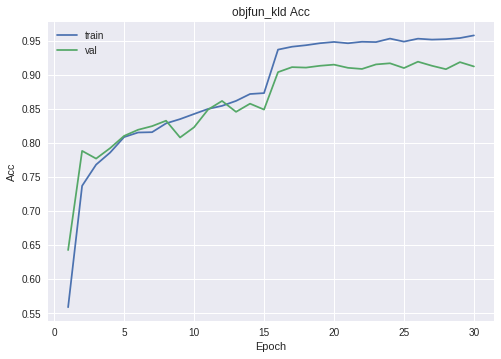

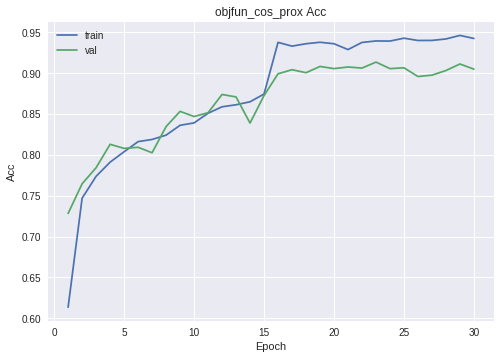

In [0]:
# helper class for copying history
class hist:
  history = {'loss':[],
            'val_loss':[],
            'acc':[],
            'val_acc':[]}

  
finalhist = hist()
aveloss_beg = []
aveloss_end = []

for idx in range(len(names)):
  finalhist.history['acc'] = mod_hist[idx].history['acc'] + mod_hist[idx + len(names)].history['acc']
  finalhist.history['val_acc'] = mod_hist[idx].history['val_acc'] + mod_hist[idx + len(names)].history['val_acc']
  plot_model_history(finalhist, names[idx], plotacc = True , plotloss = False)
  
  # get average val loss for comparison
  aveloss_beg.append(sum(mod_hist[idx].history['val_acc'][-5:] ) /5.0)
  aveloss_end.append(sum(mod_hist[idx + len(names)].history['val_acc'][-5:] )/5.0)

In [0]:
print(names)
print(aveloss_beg)
print(aveloss_end)

['objfun_crossent', 'objfun_mse', 'objfun_ch', 'objfun_msle', 'objfun_kld', 'objfun_cos_prox']
[0.8635333335876465, 0.8598000003178916, 0.7711333333651226, 0.8591333333015442, 0.8526000001907349, 0.8616666667302451]
[0.9129999999046327, 0.9120666665712992, 0.9008666666666667, 0.9111333331743877, 0.9143999997138976, 0.902666666730245]


#### loss comparison

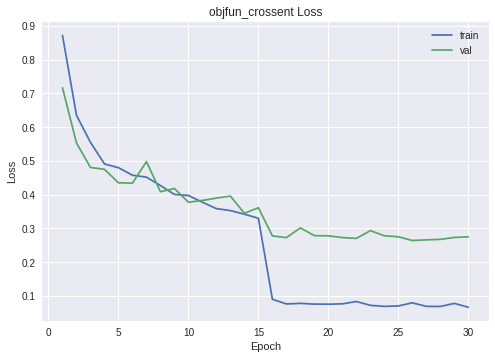

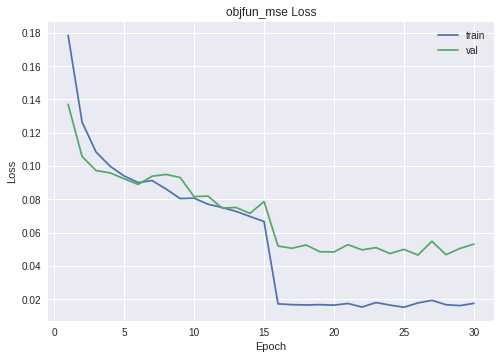

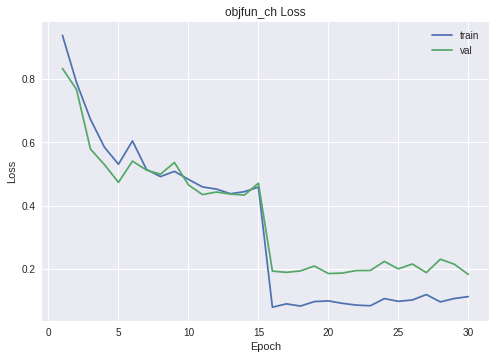

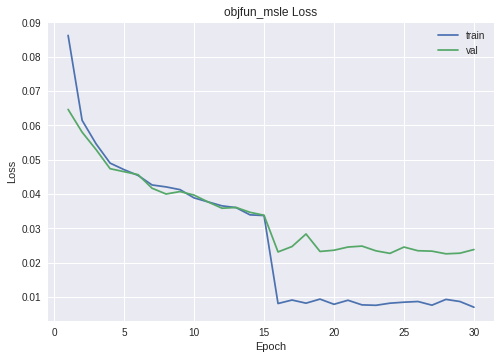

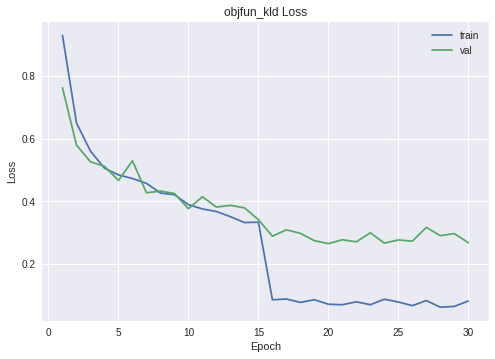

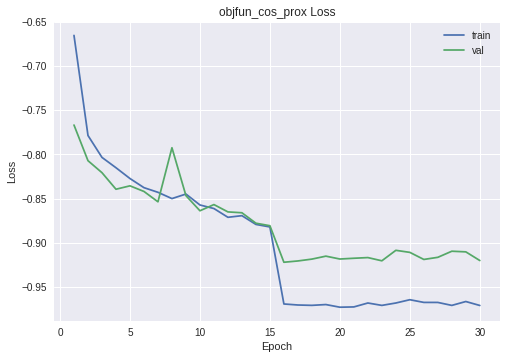

In [0]:
finalhist = []
for idx in range(len(names)):
  finalhist = mod_hist[idx].copy()
  finalhist.history['loss'] = mod_hist[idx].history['loss'] + mod_hist[idx + len(names)].history['loss']
  finalhist.history['val_loss'] = mod_hist[idx].history['val_loss'] + mod_hist[idx + len(names)].history['val_loss']
  plot_model_history(finalhist, names[idx], plotacc = False)
  
  

In [0]:
# get average val loss for comparison
aveloss_beg = []
aveloss_end = []
for idx in range(len(names)):
  aveloss_beg.append(sum(mod_hist[idx].history['val_loss'][-5:] ) /5.0)
  aveloss_end.append(sum(mod_hist[idx + len(names)].history['val_loss'][-5:] )/5.0)

print(names)
print(aveloss_beg)
print(aveloss_end)

['objfun_crossent', 'objfun_mse', 'objfun_ch', 'objfun_msle', 'objfun_kld', 'objfun_cos_prox']
[0.2692772831281026, 0.05042370995680492, 0.20617524393399553, 0.02319133888979753, 0.2887363355000814, -0.9150216941833497]
[0.2692772831281026, 0.05042370995680492, 0.20617524393399553, 0.02319133888979753, 0.2887363355000814, -0.9150216941833497]


In [0]:
# temp: recovering data for avelossbeg
aveloss_beg = []
for idx in range(len(names)):
  aveloss_beg.append(sum(mod_hist[idx].history['val_loss'][-(5+len(mod_hist[idx + len(names)].history['val_loss'])):-len(mod_hist[idx + len(names)].history['val_loss'])] ) /5.0)

print(aveloss_beg)

[0.3749290309906006, 0.07645984472036362, 0.44356846154530843, 0.03561182089547317, 0.38065770610173544, -0.8693248897870381]


### Optimizer Functions Comparison (default except SGD)

In [0]:
# ref: model_trainer(Simmodel, 'baseline_simmodel', 100, Adam(), 'categorical_crossentropy', batch_size=128,  save = True)
mod_hist = []
_time = []
epochs = 15
names = ['opt_SGD', 'opt_Adam', 'opt_Nadam', 'opt_Adamax', 'opt_Adadelta', 'opt_Adagrad']

### comparing training on early stage learning
simmodel = Simmodel()
hist,_t  = model_trainer(simmodel, names[0], epochs, SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=True), 'categorical_crossentropy')
mod_hist.append(hist)

simmodel = Simmodel()
hist,_t  = model_trainer(simmodel, names[1], epochs, Adam(), 'categorical_crossentropy')
mod_hist.append(hist)

simmodel = Simmodel()
hist,_t = model_trainer(simmodel, names[2], epochs, Nadam(), 'categorical_crossentropy')
mod_hist.append(hist)

simmodel = Simmodel()
hist,_t = model_trainer(simmodel, names[3], epochs, Adamax(), 'categorical_crossentropy')
mod_hist.append(hist)

simmodel = Simmodel()
hist,_t = model_trainer(simmodel, names[4], epochs, Adadelta(), 'categorical_crossentropy')
mod_hist.append(hist)

simmodel = Simmodel()
hist,_t = model_trainer(simmodel, names[5], epochs, Adagrad(), 'categorical_crossentropy')
mod_hist.append(hist)


### compare training on saturated model learning
# trained_model = loadmodel(Simmodel,'baseline_simmodel')
trained_model = Simmodel()
trained_model.load_weights('baseline_simmodel' + '_weights.hdf')
hist,_t = model_trainer(trained_model, names[0]+'_sat', epochs, SGD(), 'categorical_crossentropy')
mod_hist.append(hist)

trained_model = Simmodel()
trained_model.load_weights('baseline_simmodel' + '_weights.hdf')
hist,_t = model_trainer(trained_model, names[1]+'_sat', epochs, Adam(), 'categorical_crossentropy')
mod_hist.append(hist)

trained_model = Simmodel()
trained_model.load_weights('baseline_simmodel' + '_weights.hdf')
hist,_t = model_trainer(trained_model, names[2]+'_sat', epochs, Nadam(), 'categorical_crossentropy')
mod_hist.append(hist)

trained_model = Simmodel()
trained_model.load_weights('baseline_simmodel' + '_weights.hdf')
hist,_t = model_trainer(trained_model, names[3]+'_sat', epochs, Adamax(), 'categorical_crossentropy')
mod_hist.append(hist)

trained_model = Simmodel()
trained_model.load_weights('baseline_simmodel' + '_weights.hdf')
hist,_t = model_trainer(trained_model, names[4]+'_sat', epochs, Adadelta(), 'categorical_crossentropy')
mod_hist.append(hist)

trained_model = Simmodel()
trained_model.load_weights('baseline_simmodel' + '_weights.hdf')
hist,_t = model_trainer(trained_model, names[5]+'_sat', epochs, Adagrad(), 'categorical_crossentropy')
mod_hist.append(hist)

Training model: opt_SGD
Train on 10050 samples, validate on 3000 samples
Epoch 1/15
10050/10050 [==============================] - 14s 1ms/step - loss: 1.0884 - acc: 0.3862 - val_loss: 1.0702 - val_acc: 0.4530

Epoch 00001: val_acc improved from -inf to 0.45300, saving model to /tmp/opt_SGDbestweights.hdf5
Epoch 2/15
10050/10050 [==============================] - 4s 356us/step - loss: 1.0012 - acc: 0.5105 - val_loss: 0.9271 - val_acc: 0.6117

Epoch 00002: val_acc improved from 0.45300 to 0.61167, saving model to /tmp/opt_SGDbestweights.hdf5
Epoch 3/15
10050/10050 [==============================] - 3s 344us/step - loss: 0.8217 - acc: 0.6186 - val_loss: 0.7346 - val_acc: 0.6840

Epoch 00003: val_acc improved from 0.61167 to 0.68400, saving model to /tmp/opt_SGDbestweights.hdf5
Epoch 4/15
10050/10050 [==============================] - 4s 351us/step - loss: 0.7025 - acc: 0.6730 - val_loss: 0.6803 - val_acc: 0.7060

Epoch 00004: val_acc improved from 0.68400 to 0.70600, saving model to /tmp

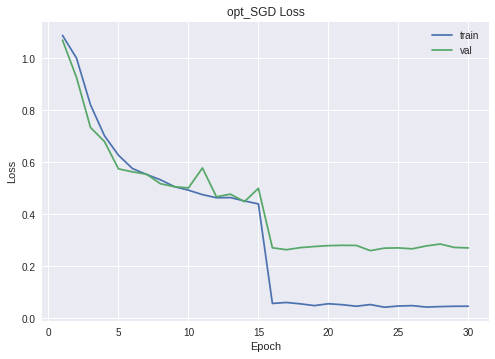

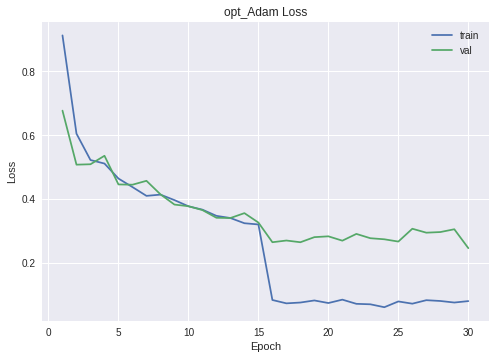

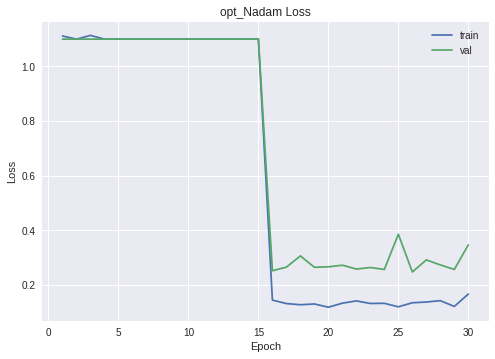

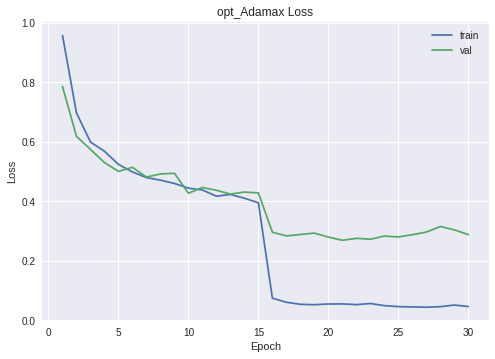

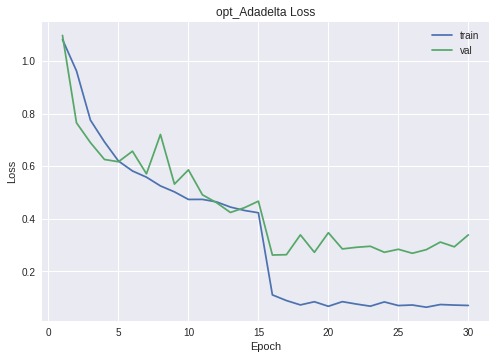

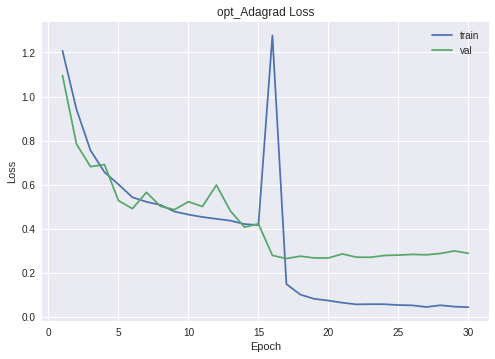

In [0]:
# helper class for copying history
class hist:
  history = {'loss':[],
            'val_loss':[],
            'acc':[],
            'val_acc':[]}

  
finalhist = hist()
aveloss_beg = []
aveloss_end = []

for idx in range(len(names)):
#   finalhist = mod_hist[idx].copy()
  finalhist.history['loss'] = mod_hist[idx].history['loss'] + mod_hist[idx + len(names)].history['loss']
  finalhist.history['val_loss'] = mod_hist[idx].history['val_loss'] + mod_hist[idx + len(names)].history['val_loss']
  plot_model_history(finalhist, names[idx], plotacc = False)
  
  # get average val loss for comparison
  aveloss_beg.append(sum(mod_hist[idx].history['val_loss'][-5:] ) /5.0)
  aveloss_end.append(sum(mod_hist[idx + len(names)].history['val_loss'][-5:] )/5.0)

In [0]:
# # get average val loss for comparison
# aveloss_beg = []
# aveloss_end = []
# for idx in range(len(names)):
#   aveloss_beg.append(sum(mod_hist[idx].history['val_loss'][-5:] ) /5.0)
#   aveloss_end.append(sum(mod_hist[idx + len(names)].history['val_loss'][-5:] )/5.0)

print(names)
print(aveloss_beg)
print(aveloss_end)

['opt_SGD', 'opt_Adam', 'opt_Nadam', 'opt_Adamax', 'opt_Adadelta', 'opt_Adagrad']
[0.49480156289736427, 0.34625019545555114, 1.098614731280009, 0.4331898098627726, 0.4567789583524068, 0.48145659635861715]
[0.2754434054374695, 0.2904262365659078, 0.2832828315973282, 0.2982370129187902, 0.2985964001576106, 0.28765294218858084]


# 'Striving for Simplicity' Paper's  All-CNN C model 

The main differences of the below adpated model and training methods from paper is input dropout,  ZCA whitening, and contrast normalization is not applied. In addition to the image augmentation via translation and horizontal flipping conducted in the paper's tests, additional augmentation is applied in the tests below. Batch normalizaion is applied whereas it is not mentioned if it is used in paper. Also the Adam optimizer will be used instead of SGD with momentum. Otherwise, very similar architecture and number of parameters (~1.3M). The hyperparameters for the model is tuned as needed accordingly. In essance of time and resources, less epochs is conducted than the papers 350.

L2 regularisation of the weights in loss function is applied to penalizes peaky weights and makes sure that all the inputs are considered more evenlly

In [0]:
def SS_model2(nb_classes):
    weight_decay = 0.0005
    model = Sequential()
    model.add(Conv2D(96,(3, 3), padding='same', input_shape=X_train.shape[1:], kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(Conv2D(96,(3, 3), padding ='same', kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(Conv2D(96,(3, 3), padding ='same', strides =(2,2), kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Conv2D(192,(3, 3), padding ='same', kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(Conv2D(192,(3, 3), padding ='same', kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(Conv2D(192,(3, 3), padding ='same',strides =(2,2), kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Conv2D(192,(3, 3), padding ='valid', kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(Conv2D(192,(1, 1), padding ='same', kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(Conv2D(nb_classes,(1, 1), padding ='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))
    
    model.add(Conv2D(nb_classes,(6, 6)))
#     model.add(AveragePooling2D(pool_size=(6, 6)))
    model.add(Flatten())  
    model.add(Activation('softmax'))

    opt = Adam()
#     opt = SGD(lr=0.00, momentum=0.4, decay=0, nesterov=True)
#     opt = RMSprop(lr=0.00)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

nb_classes = 3
cnn_sn = SS_model2(nb_classes)
cnn_sn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 32, 32, 96)        2688      
_________________________________________________________________
activation_63 (Activation)   (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 32, 32, 96)        83040     
_________________________________________________________________
activation_64 (Activation)   (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 16, 16, 96)        83040     
_________________________________________________________________
activation_65 (Activation)   (None, 16, 16, 96)        0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 16, 16, 96)        384       
__________

In [0]:
def lr_schedule2(epoch):
    lrate = 0.0004
    if epoch > 50:
        lrate = 0.0002
    elif epoch > 70:
        lrate = 0.000075 
    elif epoch > 80:
        lrate = 0.00003
    elif epoch > 90:
        lrate = 0.00001
    return lrate

# save best weights over all epochs
filepath="/tmp/CNN_SS_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

lr_sche = LearningRateScheduler(lr_schedule2)
callbacks_list = [checkpoint, lr_sche]

In [0]:
# training
epochs = 100

start_time = time.time()
cnn_hist = cnn_sn.fit(X_train, Y_train,
                    batch_size=batch_size,
                    nb_epoch=epochs,
                    verbose=1,
                    validation_data=(X_test, Y_test),
                    callbacks=callbacks_list)
elapsed_time = time.time() - start_time
model.save('/tmp/cifar10_CNN_SS.h5', overwrite=True)

/usr/local/lib/python3.6/dist-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 15000 samples, validate on 3000 samples
Epoch 1/100
15000/15000 [==============================] - 20s 1ms/step - loss: 1.2157 - acc: 0.6953 - val_loss: 1.3115 - val_acc: 0.6083

Epoch 00001: val_acc improved from -inf to 0.60833, saving model to /tmp/CNN_SS_weights.best.hdf5
Epoch 2/100
15000/15000 [==============================] - 16s 1ms/step - loss: 0.9613 - acc: 0.7763 - val_loss: 1.2531 - val_acc: 0.5733

Epoch 00002: val_acc did not improve from 0.60833
Epoch 3/100
15000/15000 [==============================] - 16s 1ms/step - loss: 0.8381 - acc: 0.8027 - val_loss: 0.9240 - val_acc: 0.7450

Epoch 00003: val_acc improved from 0.60833 to 0.74500, saving model to /tmp/CNN_SS_weights.best.hdf5
Epoch 4/100
15000/15000 [==============================] - 16s 1ms/step - loss: 0.7466 - acc: 0.8291 - val_loss: 0.8516 - val_acc: 0.7663

Epoch 00004: val_acc improved from 0.74500 to 0.76633, saving model to /tmp/CNN_SS_weights.best.hdf5
Epoch 5/100
15000/15000 [====================

NameError: ignored

### Varient 1: Global Ave Pooling Last Layer

3000/3000 [==============================] - 1s 474us/step
Test loss: 0.33607886409759524
Test acc: 0.9173333333333333
Total training time: 1625.0041172504425
3000/3000 [==============================] - 2s 558us/step
Test loss: 0.252030819495519
Test acc: 0.9379999998410543


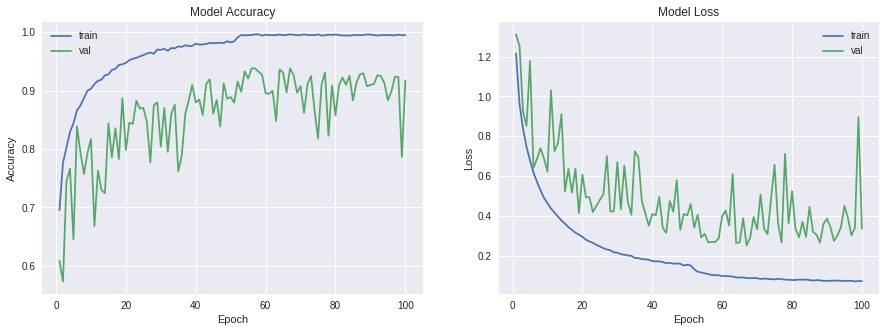

In [0]:
loss, acc = cnn_sn.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', loss)
print('Test acc:', acc)
print('Total training time:', elapsed_time)


best_model = SS_model2(3)
best_model.load_weights(filepath)
loss, acc = best_model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', loss)
print('Test acc:', acc)

plot_model_history(cnn_hist)

### Varient 2: Conv Pooling Last Layer (weighted feature downsample)

3000/3000 [==============================] - 2s 534us/step
Test loss: 0.5728905131022135
Test acc: 0.905
Total training time: 2543.9082860946655


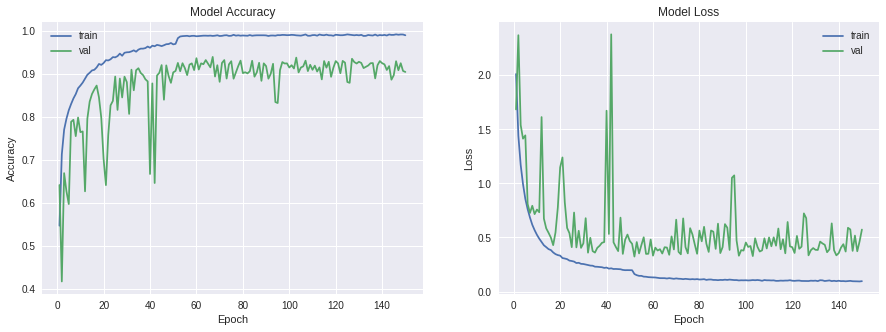

In [0]:
loss, acc = cnn_sn.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', loss)
print('Test acc:', acc)
print('Total training time:', elapsed_time)
plot_model_history(cnn_hist)

### Varient 2 and Training With data augmentation

In [0]:
def lr_schedule2(epoch):
    lrate = 0.0002
    if epoch > 50:
        lrate = 0.0001
    elif epoch > 100:
        lrate = 0.00004
    elif epoch > 120:
        lrate = 0.00002
    elif epoch > 130:
        lrate = 0.0000075
    return lrate
  
  # save best weights over all epochs
filepath="/tmp/CNN_SS_weights_DA.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

lr_sche = LearningRateScheduler(lr_schedule2)
callbacks_list = [checkpoint, lr_sche]

In [0]:
# with data augmentation
cnn_da = SS_model2(nb_classes)

datagen = ImageDataGenerator(rotation_range=15, 
                 width_shift_range=0.1667, height_shift_range=0.1667,
                             zoom_range = 0.2,
                 fill_mode='nearest', horizontal_flip=True) 

# Fit model
nb_epoch = 150
start_time = time.time()
# Fit the model on the batches generated by datagen.flow().
cnnda_hist = cnn_da.fit_generator(datagen.flow(X_train, Y_train,
                                  batch_size=batch_size),
                                  epochs=nb_epoch,
                                  validation_data=(X_test, Y_test),
                                  workers=4,
                                  callbacks=callbacks_list)

# Train for some more epochs w/o data transform
cnnda_hist2 = cnn_da.fit(X_train, Y_train, batch_size=batch_size, epochs=20, validation_data=(X_test,Y_test), callbacks=callbacks_list)
elapsed_time = time.time() - start_time

model.save('/tmp/cifar10_CNN_SS_DA.h5', overwrite=True)

Epoch 1/150
321/391 [=======================>......] - ETA: 11s - loss: 3.0873 - acc: 0.2078

KeyboardInterrupt: ignored

In [0]:
loss, acc = cnn_da.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', loss)
print('Test acc:', acc)
print('Total training time:', elapsed_time)

best_model = SS_model2()
best_model.load_weights(filepath)
loss, acc = best_model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', loss)
print('Test acc:', acc)


# concactnate all history data
for index , data in enumerate(cnnda_hist2.history,1):
  cnnda_hist.history[data] = cnnda_hist.history[data] + cnnda_hist2.history[data]

3000/3000 [==============================] - 2s 559us/step
Test loss: 0.2229741473197937
Test acc: 0.9559999998410543
Total training time: 2659.6380939483643
3000/3000 [==============================] - 3s 1ms/step
Test loss: 0.2342912128766378
Test acc: 0.9586666668256124


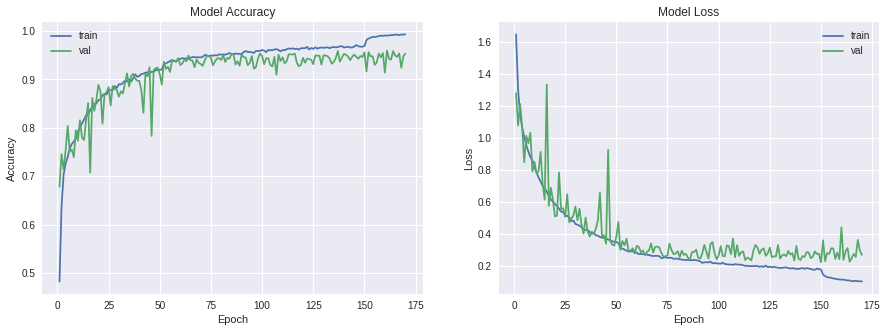

In [0]:
plot_model_history(cnnda_hist)

# Full Dataset Training

## Test 1: SS_model

less regularization for full model since less likely for parameters to overfit with 3.33x more classes

In [0]:
# download data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()  
# More Preprocessing
batch_size = 128

X_train = x_train.astype('float32')
X_test = x_test.astype('float32')
X_train /= 255.0 # normalize 8-bit pixels
X_test /= 255.0

# convert the labels in the dataset into categorical matrix structure from 1-dim numpy array structure
# one hot encode
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [0]:
cnn_da10 = SS_model2(nb_classes)

In [0]:
def lr_schedule2(epoch):
    lrate = 0.0004
    if epoch > 50:
        lrate = 0.0002
    elif epoch > 100:
        lrate = 0.00001
    elif epoch > 120:
        lrate = 0.00005
    elif epoch > 130:
        lrate = 0.00002
    return lrate
  
  # save best weights over all epochs
filepath="/tmp/CNN_SS_weights_DA10.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

lr_sche = LearningRateScheduler(lr_schedule2)
callbacks_list = [checkpoint, lr_sche]

# with data augmentation
datagen = ImageDataGenerator(rotation_range=15, 
                 width_shift_range=0.1667, height_shift_range=0.1667,
                             zoom_range = 0.2,
                 fill_mode='nearest', horizontal_flip=True) 

In [0]:
nb_epoch = 150
start_time = time.time()
# Fit the model on the batches generated by datagen.flow().
cnnda10_hist = cnn_da10.fit_generator(datagen.flow(X_train, Y_train,
                                  batch_size=batch_size),
                                  epochs=nb_epoch,
                                  validation_data=(X_test, Y_test),
                                  workers=4,
                                  callbacks=callbacks_list,
                                  verbose = 2)

# Train for some more epochs w/o data transform
# cnnda_hist2 = cnn_da.fit(X_train, Y_train, batch_size=batch_size, epochs=20, validation_data=(X_test,Y_test), callbacks=callbacks_list)
elapsed_time = time.time() - start_time


Epoch 1/150
391/391 [==============================] - 60s 153ms/step - loss: 2.6016 - acc: 0.2435 - val_loss: 2.0679 - val_acc: 0.4000

Epoch 00001: val_acc improved from -inf to 0.40000, saving model to /tmp/CNN_SS_weights_DA10.best.hdf5
Epoch 2/150
391/391 [==============================] - 56s 142ms/step - loss: 2.0949 - acc: 0.3533 - val_loss: 1.7341 - val_acc: 0.4659

Epoch 00002: val_acc improved from 0.40000 to 0.46590, saving model to /tmp/CNN_SS_weights_DA10.best.hdf5
Epoch 3/150
391/391 [==============================] - 56s 142ms/step - loss: 1.7936 - acc: 0.4329 - val_loss: 1.5454 - val_acc: 0.5215

Epoch 00003: val_acc improved from 0.46590 to 0.52150, saving model to /tmp/CNN_SS_weights_DA10.best.hdf5
Epoch 4/150
391/391 [==============================] - 56s 142ms/step - loss: 1.5969 - acc: 0.4963 - val_loss: 1.7650 - val_acc: 0.5072

Epoch 00004: val_acc did not improve from 0.52150
Epoch 5/150
391/391 [==============================] - 55s 142ms/step - loss: 1.4647 - 

NameError: ignored

In [0]:
cnn_da10.save('/tmp/cifar10_CNN_SS_DA10.h5', overwrite=True)

10000/10000 [==============================] - 5s 500us/step
Test loss: 0.5677421754837036
Test acc: 0.8858
Total training time: 8303.126951932907
10000/10000 [==============================] - 5s 487us/step
Test loss: 0.4902198142528534
Test acc: 0.9021


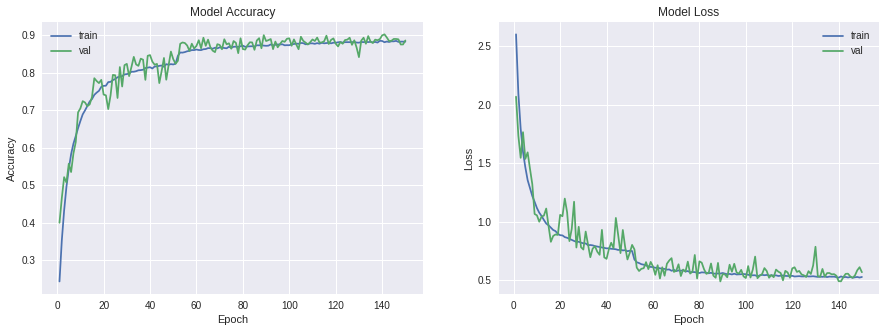

In [0]:
loss, acc = cnn_da10.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', loss)
print('Test acc:', acc)
print('Total training time:', elapsed_time)

best_model = SS_model2(nb_classes)
best_model.load_weights(filepath)
loss, acc = best_model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', loss)
print('Test acc:', acc)

plot_model_history(cnnda10_hist)

## Test 2: SS_model with Much Less Regularization

significantly decreased weight decay and dropout relative to model for 3 class, requireing redifinition of model

In [0]:
def SS_model_10(nb_classes):
    weight_decay = 0.00001
#     weight_decay = 0.00003
    model = Sequential()
    model.add(Conv2D(96,(3, 3), padding='same', input_shape=X_train.shape[1:], kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(Conv2D(96,(3, 3), padding ='same', kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(Conv2D(96,(3, 3), padding ='same', strides =(2,2), kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(192,(3, 3), padding ='same', kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(Conv2D(192,(3, 3), padding ='same', kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(Conv2D(192,(3, 3), padding ='same',strides =(2,2), kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Conv2D(192,(3, 3), padding ='valid', kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(Conv2D(192,(1, 1), padding ='same', kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(Conv2D(nb_classes,(1, 1), padding ='same', kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    model.add(Conv2D(nb_classes,(6, 6)))
    model.add(Flatten())  
    model.add(Activation('softmax'))

    opt = Adam(lr=0.000)
#     opt = SGD(lr=0.00, momentum=0.4, decay=0, nesterov=True)
#     opt = RMSprop(lr=0.00)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

nb_classes = 10
cnn_da10_2 = SS_model_10(nb_classes)

In [0]:
def lr_schedule2(epoch):
    lrate = 0.001
    if epoch > 60:
        lrate = 0.0001
    elif epoch > 100:
        lrate = 0.00001
    elif epoch > 130:
        lrate = 0.000002
    return lrate
  
  # save best weights over all epochs
filepath="/tmp/CNN_SS_weights_DA10_2.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
lr_sche = LearningRateScheduler(lr_schedule2)
callbacks_list = [checkpoint, lr_sche]

# with data augmentation
datagen = ImageDataGenerator(rotation_range=15, 
                 width_shift_range=0.1667, height_shift_range=0.1667,
                             zoom_range = 0.2,
                 fill_mode='nearest', horizontal_flip=True) 

In [0]:
nb_epoch = 150

start_time = time.time()
# Fit the model on the batches generated by datagen.flow().
cnnda10_2_hist = cnn_da10_2.fit_generator(datagen.flow(X_train, Y_train,
                                  batch_size=batch_size),
                                  epochs=nb_epoch,
                                  validation_data=(X_test, Y_test),
                                  workers=4,
                                  callbacks=callbacks_list,
                                  verbose = 1)

elapsed_time = time.time() - start_time
cnn_da10_2.save('/tmp/cifar10_CNN_SS_DA10_2.h5', overwrite=True)

Epoch 1/150
391/391 [==============================] - 61s 156ms/step - loss: 1.9262 - acc: 0.3083 - val_loss: 1.7076 - val_acc: 0.3767

Epoch 00001: val_acc improved from -inf to 0.37670, saving model to /tmp/CNN_SS_weights_DA10_2.best.hdf5
Epoch 2/150
391/391 [==============================] - 56s 144ms/step - loss: 1.5434 - acc: 0.4379 - val_loss: 1.7902 - val_acc: 0.3543

Epoch 00002: val_acc did not improve from 0.37670
Epoch 3/150
391/391 [==============================] - 56s 144ms/step - loss: 1.3730 - acc: 0.5022 - val_loss: 1.4327 - val_acc: 0.4982

Epoch 00003: val_acc improved from 0.37670 to 0.49820, saving model to /tmp/CNN_SS_weights_DA10_2.best.hdf5
Epoch 4/150
391/391 [==============================] - 56s 144ms/step - loss: 1.2385 - acc: 0.5597 - val_loss: 1.1501 - val_acc: 0.5984

Epoch 00004: val_acc improved from 0.49820 to 0.59840, saving model to /tmp/CNN_SS_weights_DA10_2.best.hdf5
Epoch 5/150
391/391 [==============================] - 56s 144ms/step - loss: 1.1

10000/10000 [==============================] - 5s 508us/step
Test loss: 0.39057528982162476
Test acc: 0.9209
Total training time: 8462.71255326271
10000/10000 [==============================] - 5s 499us/step
Test loss: 0.3905752929210663
Test acc: 0.9209


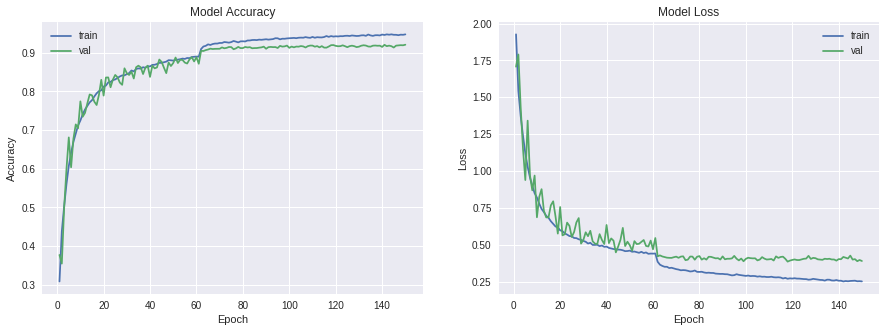

In [0]:
loss, acc = cnn_da10_2.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', loss)
print('Test acc:', acc)
print('Total training time:', elapsed_time)

best_model = SS_model_10(nb_classes)
best_model.load_weights(filepath)
loss, acc = best_model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', loss)
print('Test acc:', acc)

plot_model_history(cnnda10_2_hist)

# Wide ResNet

In [0]:
from keras.layers import Input, add, AveragePooling2D
from keras.callbacks import LearningRateScheduler
from keras.regularizers import l2
from keras import optimizers
from keras.models import Model

# size 1
# DEPTH              = 28
# WIDE               = 10
# size 2
DEPTH              = 16
WIDE               = 8

IN_FILTERS         = 16

CLASS_NUM          = 3 # for test
nb_classes = 3


IMG_ROWS, IMG_COLS = 32, 32
IMG_CHANNELS       = 3

BATCH_SIZE         = 128
EPOCHS             = 150
# ITERATIONS         = 50000 // BATCH_SIZE + 1 # for full dataset
ITERATIONS         = 15000 // BATCH_SIZE + 1   # for 3 class dataset
WEIGHT_DECAY       = 0.0005
LOG_FILE_PATH      = './w_resnet/'

def scheduler(epoch):
    if epoch < 60:
        return 0.1
    if epoch < 100:
        return 0.02
    if epoch < 130:
        return 0.004
    return 0.0008

def wide_residual_network(img_input,classes_num,depth,k):
    print('Wide-Resnet %dx%d' %(depth, k))
    n_filters  = [16, 16*k, 32*k, 64*k]
    n_stack    = (depth - 4) // 6

    def conv3x3(x,filters):
        return Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1), padding='same',
        kernel_initializer='he_normal',
        kernel_regularizer=l2(WEIGHT_DECAY),
        use_bias=False)(x)

    def bn_relu(x):
        x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
        x = Activation('relu')(x)
        return x

    def residual_block(x,out_filters,increase=False):
        global IN_FILTERS
        stride = (1,1)
        if increase:
            stride = (2,2)
            
        o1 = bn_relu(x)
        
        conv_1 = Conv2D(out_filters,
            kernel_size=(3,3),strides=stride,padding='same',
            kernel_initializer='he_normal',
            kernel_regularizer=l2(WEIGHT_DECAY),
            use_bias=False)(o1)

        o2 = bn_relu(conv_1)
        
        conv_2 = Conv2D(out_filters, 
            kernel_size=(3,3), strides=(1,1), padding='same',
            kernel_initializer='he_normal',
            kernel_regularizer=l2(WEIGHT_DECAY),
            use_bias=False)(o2)
        if increase or IN_FILTERS != out_filters:
            proj = Conv2D(out_filters,
                                kernel_size=(1,1),strides=stride,padding='same',
                                kernel_initializer='he_normal',
                                kernel_regularizer=l2(WEIGHT_DECAY),
                                use_bias=False)(o1)
            block = add([conv_2, proj])
        else:
            block = add([conv_2,x])
        return block

    def wide_residual_layer(x,out_filters,increase=False):
        global IN_FILTERS
        x = residual_block(x,out_filters,increase)
        IN_FILTERS = out_filters
        for _ in range(1,int(n_stack)):
            x = residual_block(x,out_filters)
        return x


    x = conv3x3(img_input,n_filters[0])
    x = wide_residual_layer(x,n_filters[1])
    x = wide_residual_layer(x,n_filters[2],increase=True)
    x = wide_residual_layer(x,n_filters[3],increase=True)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
    x = Activation('relu')(x)
    x = AveragePooling2D((8,8))(x)
    x = Flatten()(x)
    x = Dense(classes_num,
        activation='softmax',
        kernel_initializer='he_normal',
        kernel_regularizer=l2(WEIGHT_DECAY),
        use_bias=False)(x)
    return x

# ref https://github.com/BIGBALLON/cifar-10-cnn/blob/master/5_Wide_Residual_Network/Wide_ResNet_keras.py

In [0]:
# build network
img_input = Input(shape=(IMG_ROWS,IMG_COLS,IMG_CHANNELS))

output = wide_residual_network(img_input,CLASS_NUM,DEPTH,WIDE)
resnet = Model(img_input, output)
print(resnet.summary())

# set optimizer
sgd = optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
resnet.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# set callback
# filepath="/tmp/WideRes_weights.{epoch:02d}.best.hdf5"
filepath="WideRes_weights.{epoch:02d}.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
change_lr = LearningRateScheduler(scheduler)
cbks = [change_lr, checkpoint]

# Moderate data augmentation that worked well before
datagen = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.125, 
                             height_shift_range=0.125, zoom_range = 0.125, fill_mode='reflect')

datagen.fit(X_train)


Wide-Resnet 16x8
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_153 (Conv2D)             (None, 32, 32, 16)   432         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_66 (BatchNo (None, 32, 32, 16)   64          conv2d_153[0][0]                 
__________________________________________________________________________________________________
activation_150 (Activation)     (None, 32, 32, 16)   0           batch_normalization_66[0][0]     
____________________________________________________________________________________________

## 3 class (small augment)

trained with colour preprocessing and the following data augmentation
horizontal_flip=True, width_shift_range=0.125,height_shift_range=0.125,fill_mode='reflect'

In [0]:
# start training
start_time = time.time()
wideresnet_hist = resnet.fit_generator(datagen.flow(X_train,Y_train,batch_size=BATCH_SIZE),
                    epochs=EPOCHS,
                    callbacks=cbks,
                    validation_data=(X_test, Y_test),
                    workers=4,
                    verbose = 1)
resnet.save('wresnet.h5')
end_time = time.time() - start_time



Epoch 1/150
118/118 [==============================] - 76s 647ms/step - loss: 3.8168 - acc: 0.7253 - val_loss: 3.7979 - val_acc: 0.6643
Epoch 2/150
118/118 [==============================] - 53s 447ms/step - loss: 3.0071 - acc: 0.7977 - val_loss: 2.8832 - val_acc: 0.6987
Epoch 3/150
118/118 [==============================] - 53s 452ms/step - loss: 2.4203 - acc: 0.8308 - val_loss: 3.0953 - val_acc: 0.6330
Epoch 4/150
118/118 [==============================] - 53s 451ms/step - loss: 1.9750 - acc: 0.8514 - val_loss: 1.7703 - val_acc: 0.8633
Epoch 5/150
118/118 [==============================] - 54s 458ms/step - loss: 1.6096 - acc: 0.8773 - val_loss: 1.5533 - val_acc: 0.8337
Epoch 6/150
118/118 [==============================] - 53s 449ms/step - loss: 1.3436 - acc: 0.8803 - val_loss: 1.3862 - val_acc: 0.8337
Epoch 7/150
118/118 [==============================] - 53s 449ms/step - loss: 1.1243 - acc: 0.8938 - val_loss: 1.4323 - val_acc: 0.7553
Epoch 8/150
118/118 [===========================

3000/3000 [==============================] - 5s 2ms/step
Test loss: 0.1655456618865331
Test acc: 0.973


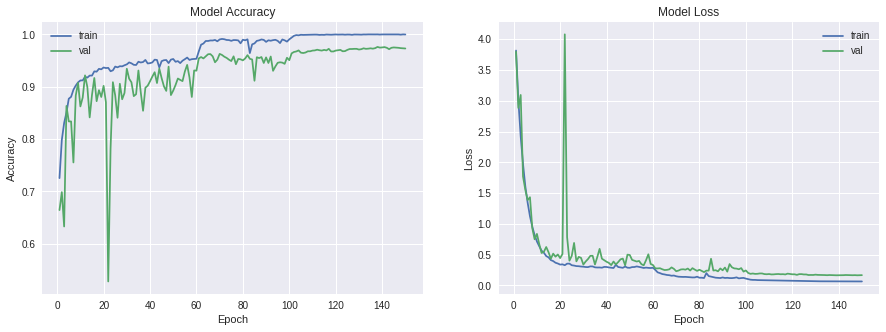

In [0]:
loss, acc = resnet.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', loss)
print('Test acc:', acc)
# print('Total training time:', elapsed_time)

plot_model_history(wideresnet_hist)